In [1]:
# !pip install pysheds netCDF4 fiona geopandas xarray pyshp

In [2]:
# IMPORT PACKAGES
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
import shapefile
import os

import netCDF4 as nc
from netCDF4 import Dataset
from shapely.geometry import Point, shape, box, mapping
from shapely.vectorized import contains
from shapely.strtree import STRtree

from rasterio.coords import BoundingBox
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import shapes

In [3]:
opened = []

file_path = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/ALL_STATIONS_ALL_MONTHS.csv'

# Export to a CSV file
stations_df = pd.read_csv(file_path)
# print(stations_df)

Precip shape: (3599, 1799)
Lat shape: (1799,) Lon shape: (3599,)


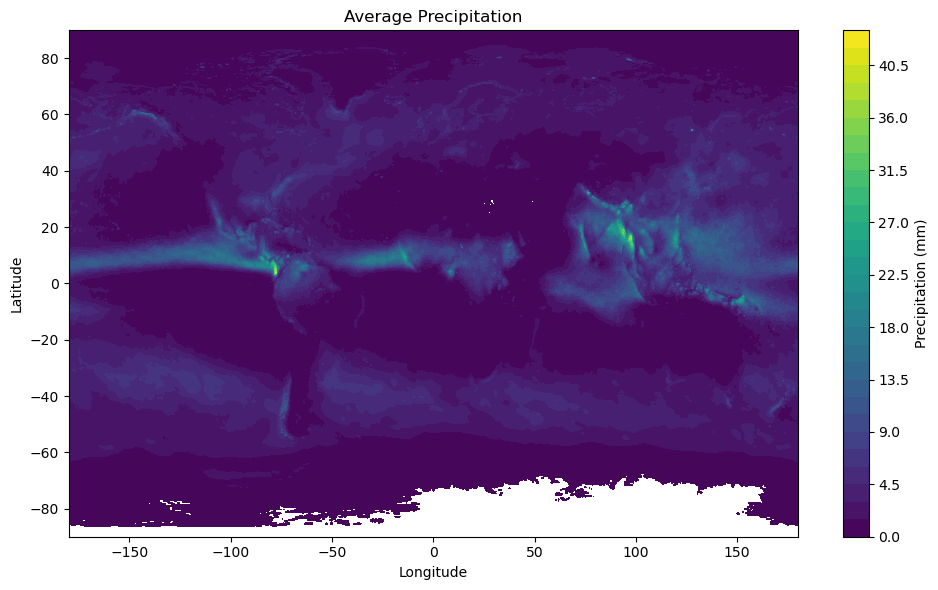

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

precip_folder = '/global/scratch/users/arvalcarcel/CSMUB/DATA/PRECIP/RESAMPLED/'

# ==== INPUT FILES ====
# shapefile_path = shapefile
netcdf_path = precip_folder + 'IMERG-Final.CLIM.2001-2022.08.V07B.nc4'  # Update to your date/month

# ==== Open NetCDF ====
ds = nc.Dataset(netcdf_path)
precip = ds.variables['precipitation'][:]
lat = ds.variables['lat'][:]
lon = ds.variables['lon'][:]

# ==== Check shape ====
print("Precip shape:", precip.shape)
print("Lat shape:", lat.shape, "Lon shape:", lon.shape)

# ==== Average over time (if needed) ====
if precip.ndim == 3:
    precip = precip.mean(axis=0)  # average over time

# ==== Fix longitudes if needed ====
if not np.all(np.diff(lon) > 0):
    print("Sorting longitudes...")
    sort_idx = np.argsort(lon)
    lon = lon[sort_idx]
    precip = precip[:, sort_idx]  # shape: (lat, lon)

# ==== Transpose precip to match lat-lon grid ====
precip = precip.T  # Now shape: (lon, lat), matching meshgrid shape

# ==== Create meshgrid ====
lon_grid, lat_grid = np.meshgrid(lon, lat)

# ==== Plot ====
plt.figure(figsize=(10, 6))
cf = plt.contourf(lon_grid, lat_grid, precip, cmap="viridis", levels=30)
plt.colorbar(cf, label="Precipitation (mm)")
plt.title("Average Precipitation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


In [5]:
def calc_avg_precip(shp_input, nc_folder, date_input):
    filename = f"IMERG-Final.CLIM.2001-2022.{date_input}.V07B.nc4"
    nc_input = os.path.join(nc_folder, filename)
    
    # Open NetCDF file and extract variables
    with nc.Dataset(nc_input) as dataset:
        precip = dataset.variables['precipitation'][:]  # shape (time, lat, lon) or (lat, lon)
        print(precip.shape)
        latitude = dataset.variables['lat'][:]  # shape (lat,)
        longitude = dataset.variables['lon'][:]  # shape (lon,)
    
    # Load and reproject the shapefile
    shp = gpd.read_file(shp_input).to_crs('EPSG:4326')
    minlon, minlat, maxlon, maxlat = shp.geometry.total_bounds
    
    # Limit the NetCDF data to the bounding box of the shapefile
    lat_mask = (latitude >= minlat) & (latitude <= maxlat)
    lon_mask = (longitude >= minlon) & (longitude <= maxlon)
    
    # Filter latitude and longitude based on the mask
    lat_filtered = latitude[lat_mask]
    lon_filtered = longitude[lon_mask]
    print(lat_filtered,lon_filtered)
    
    # Step 1: Create a grid of filtered points
    lon_grid, lat_grid = np.meshgrid(lon_filtered, lat_filtered)
    points = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])
    
    # Check the dimensionality of precip
    if precip.ndim == 2:  # If it's (lat, lon)
        precip_filtered = precip[:,lat_mask][lon_mask,:]  # Apply both lat and lon masks
    elif precip.ndim == 3:  # If it's (time, lat, lon)
        precip_filtered = precip[:, lat_mask, :][:, :, lon_mask]
    
    # Flatten the filtered precipitation array (time dimension included if 3D)
    precip_flat = precip_filtered.ravel()
    
    # Step 2: Load the shapefile and get combined geometry
    shapefile_geom = shp.geometry.unary_union  # Combine all geometries in the shapefile
    
    # Step 3: Identify points intersecting the shapefile
    intersects_mask = contains(shapefile_geom, points[:, 0], points[:, 1])
    
    # Step 4: Filter the points and precipitation values
    filtered_points = points[intersects_mask]
    filtered_precip = precip_flat[intersects_mask]
    
    avg = np.mean(filtered_precip)
    
    return avg * 1e6  # Return in mm

In [6]:
# Example call
precip = np.zeros(len(stations_df))
for i in range(0, 1):  # Only processing the first station for now
    date = stations_df['Date']
    number = stations_df['GRDC_No'][i]
    shp_log = stations_df['SHP']
    
    # Read the shapefiles based on shp_log
    shapefile1 = f'/global/home/users/arvalcarcel/ondemand/data/dem/{number}/{number}.shp' 
    shapefile2 = f'/global/scratch/users/arvalcarcel/CSMUB/DATA/SHAPEFILES/{number}/{number}.shp'
    
    if shp_log[i] == 1:
        shapefile = shapefile1
    elif shp_log[i] == 2:
        shapefile = shapefile2
    
    precip_folder = '/global/scratch/users/arvalcarcel/CSMUB/DATA/PRECIP/'
    date_input = date[i][-2:]
    
    # Compute average precipitation for this date and shapefile
    avg = calc_avg_precip(shapefile, precip_folder, date_input)
    
    # Assign result back to the matching row
    precip[i] = avg

(3600, 1800)
[-32.65 -32.55 -32.45 -32.35 -32.25 -32.15 -32.05 -31.95 -31.85 -31.75
 -31.65 -31.55 -31.45 -31.35 -31.25 -31.15 -31.05 -30.95 -30.85 -30.75
 -30.65 -30.55 -30.45 -30.35 -30.25 -30.15 -30.05 -29.95 -29.85 -29.75
 -29.65 -29.55 -29.45 -29.35 -29.25 -29.15 -29.05 -28.95 -28.85 -28.75
 -28.65 -28.55 -28.45 -28.35 -28.25 -28.15 -28.05 -27.95 -27.85 -27.75
 -27.65 -27.55 -27.45 -27.35 -27.25 -27.15 -27.05 -26.95 -26.85 -26.75
 -26.65 -26.55 -26.45 -26.35 -26.25 -26.15 -26.05 -25.95 -25.85 -25.75
 -25.65 -25.55 -25.45 -25.35 -25.25 -25.15 -25.05 -24.95 -24.85 -24.75
 -24.65 -24.55 -24.45 -24.35 -24.25 -24.15 -24.05 -23.95 -23.85 -23.75
 -23.65 -23.55 -23.45 -23.35 -23.25 -23.15 -23.05 -22.95 -22.85 -22.75
 -22.65 -22.55 -22.45 -22.35 -22.25 -22.15 -22.05 -21.95 -21.85 -21.75] [16.55 16.65 16.75 16.85 16.95 17.05 17.15 17.25 17.35 17.45 17.55 17.65
 17.75 17.85 17.95 18.05 18.15 18.25 18.35 18.45 18.55 18.65 18.75 18.85
 18.95 19.05 19.15 19.25 19.35 19.45 19.55 19.65 19.75 19.8

/tmp/ipykernel_763808/1054352044.py:39: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shapefile_geom = shp.geometry.unary_union  # Combine all geometries in the shapefile


In [7]:
stations_df['P'] = precip

In [8]:
print(stations_df)

       Unnamed: 0     Date       Q       SWE    SWE_scaled  GRDC_No  SHP  \
0               0  2018-08  24.526  2.087791  1.809042e+06  1159100    1   
1               1  2018-09  31.372  1.835435  1.590379e+06  1159100    1   
2               2  2018-10  19.572  1.976332  1.712464e+06  1159100    1   
3               3  2018-11   7.349  1.633273  1.415208e+06  1159100    1   
4               4  2018-12  13.824  1.782850  1.544815e+06  1159100    1   
...           ...      ...     ...       ...           ...      ...  ...   
23053          57  2023-05   3.046  3.400061  5.610100e+04  6594090    1   
23054          58  2023-06   2.489  3.195970  5.273351e+04  6594090    1   
23055          59  2023-07   2.021  3.656259  6.032828e+04  6594090    2   
23056          60  2023-08   2.067  3.578097  5.903860e+04  6594090    1   
23057          61  2023-09   2.483  3.630205  5.989839e+04  6594090    1   

           Area  Latitude  Avg Slope  Max Slope     Aridity    Precip  \
0      866486.

In [9]:
# opened = []

# csv_path = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/'
# masterlist = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/ALL_STATIONS_REVISED_PRECIP.csv'

# # Load the master list of stations
# stations_df = pd.read_csv(masterlist)

# # Extract station numbers, areas, and latitudes
# station_num = stations_df['grdc_no']
# station_shp = stations_df['shapefile_code']
# station_area = stations_df['area']
# station_lat = stations_df['lat']
# station_avgslope = stations_df['avg_slope']
# station_maxslope = stations_df['max_slope']
# station_aridity = stations_df['avg_aridity']
# station_precip = stations_df['P']

# # Map station numbers to areas and latitudes
# station_area_map = dict(zip(station_num, station_area))
# station_lat_map = dict(zip(station_num, station_lat))
# station_avgslope_map = dict(zip(station_num, station_avgslope))
# station_maxslope_map = dict(zip(station_num, station_maxslope))
# station_aridity_map = dict(zip(station_num, station_aridity))
# # station_precip_map = dict(zip(station_num, station_precip))

# # Generate the list of file paths
# arrayFile = [os.path.join(csv_path, f"{station_no}.csv") for station_no in station_num]
# # print(arrayFile)
# # Initialize a list to store opened DataFrames
# for file in arrayFile:
#     station_no = os.path.basename(file).split('.')[0]
#     # print(station_no)# Extract station number from the filename
#     if os.path.exists(file):  # Check if file exists
#         df = pd.read_csv(file, index_col=None, header=0)
#         station_no_int = int(station_no)  # Convert station number to integer for lookup
#         df['GRDC_No'] = station_no_int  # Add the station number as a new column
#         df['SHP'] = station_shp
#         df['Area'] = station_area_map.get(station_no_int, None)  # Add the Area column
#         df['Latitude'] = station_lat_map.get(station_no_int, None)  # Add the latitude column
#         df['Avg Slope'] = station_avgslope_map.get(station_no_int, None)
#         df['Max Slope'] = station_maxslope_map.get(station_no_int, None)
#         df['Aridity'] = station_aridity_map.get(station_no_int, None)
#         df['Precip'] = station_precip
#         opened.append(df)

# # Combine all DataFrames into one
# total_df = pd.concat(opened, axis=0, ignore_index=True)

# # Print or save the resulting DataFrame
# print(total_df)
# total_df.to_csv(file_path, index=False)